In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.utils.wavelets             import *

import pyfrac
from pyfrac.utils.sofiutils import *
from pyfrac.utils.modellingutils import *
from pyfrac.hydrafrac.acquisition import recgeom
from pyfrac.visualisation.traceviz import wiggleplot

# Rock Properties - subsurface models

In [2]:
xlim = 0.202  # 20cm
ylim = 0.102  # 10cm
zlim = 0.102  # 10cm

In [3]:
dx = dy = dz = 0.001  # 1cm
dt = 1e-7

nx = int(xlim/dx)+2
ny = int(ylim/dy)+2
nz = int(zlim/dz)+2

# Subsurface properties
vp = 5260  # m/s
vs = 3260  # m/s
rho = 2590;  # kg/m3

x, y, z = (np.arange(nx)*dx)-dx, (np.arange(ny)*dy)-dy, (np.arange(nz)*dz)-dz

print(max(x),max(y),max(z))

0.202 0.101 0.101


In [44]:
# MAKE MODELS
mod_vp = vp * np.ones([nx, ny, nz])
mod_vs = vs * np.ones([nx, ny, nz])
mod_rho = rho * np.ones([nx, ny, nz])

Text(0.5, 1.0, 'Homo.')

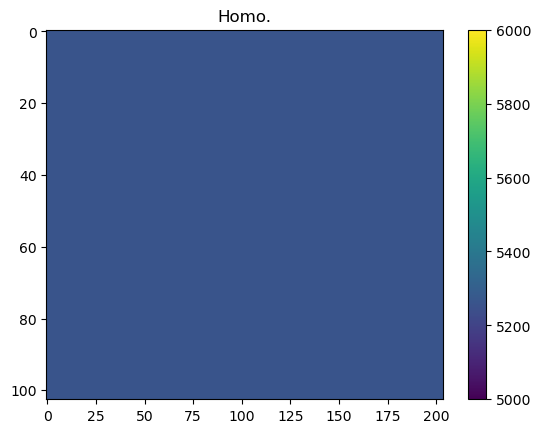

In [46]:
plt.imshow(mod_vp[:,0,:].T, aspect='auto', vmin=5000, vmax=6000, cmap='viridis')
plt.colorbar()
plt.title('Homo.')

In [47]:
# Update Vp
mod_vp[:,:,26:29] = vp + (0.1*vp)
mod_vp[:,:,56:59] = vp + (0.1*vp)
mod_vp[:,:,76:79] = vp + (0.1*vp)

Text(0.5, 1.0, '3 Sty. at 10% inc.')

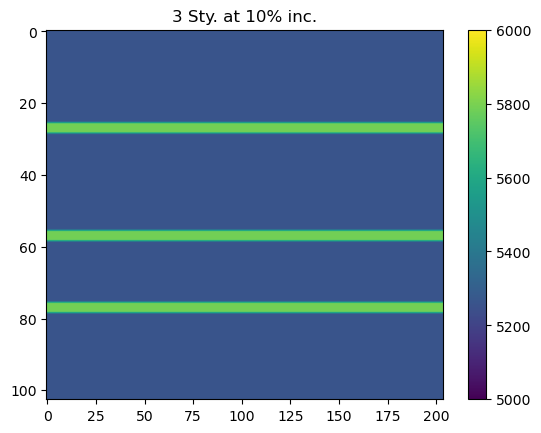

In [48]:
plt.imshow(mod_vp[:,0,:].T, aspect='auto', vmin=5000, vmax=6000, cmap='viridis')
plt.colorbar()
plt.title('3 Sty. at 10% inc.')

# Acquisition Geometry - Receivers & Source

In [49]:
# Source 
sx, sy, sz = 0.1, 0.05, 0.05
td = 0.  # ignition time
fc = 800  # central frequency
amp = 1.  # amplitude

src = np.vstack([[sx,sy,sz],[sx,sy,sz],]).T

In [50]:
recA = np.array([50, 50, 0])/1000
recB = np.array([100, 50, 0])/1000
recC = np.array([150, 50, 0])/1000

recD = np.array([50, 50, 100])/1000
recE = np.array([150, 50, 100])/1000

recF = np.array([200, 50, 50])/1000
recG = np.array([0, 50, 50])/1000

recH = np.array([50, 0, 50])/1000
recI = np.array([100, 0, 50])/1000
recJ = np.array([150, 0, 50])/1000

recK = np.array([50, 100, 50])/1000
recL = np.array([100, 100, 50])/1000
recM = np.array([150, 100, 50])/1000



recs=np.vstack([recA,recB,recC,recD,
                recE,recF,recG,recH,
                recI,recJ,recK,recL, recM
               ]).T
nr = recs.shape[1]

print(recs.shape)

(3, 13)


In [51]:
np.max(recs,axis=1)

array([0.2, 0.1, 0.1])

# TRAVELS TIMES

In [8]:
trav = Kirchhoff._traveltime_table(z, x,
                                   src, 
                                   recs, 
                                   mod_vp, 
                                   y=y, 
                                   mode='eikonal')[1]


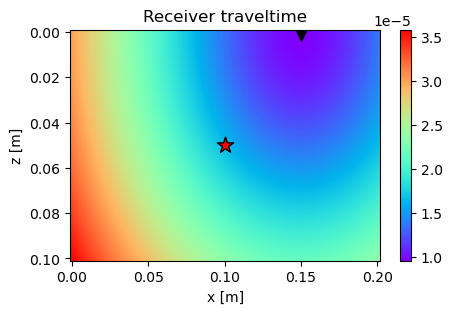

In [9]:
# JUST PLOTTING
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
im = ax.imshow(trav[:,2].reshape((nx, ny, nz))[:,0,:].T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, 2], recs[2, 2], marker='v', s=150, c='k', edgecolors='k')
ax.scatter(src[0, 0], src[2, 0], marker='*', s=150, c='r', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_title('Receiver traveltime')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

In [10]:
tttable = trav.reshape((nx, ny, nz, nr))

In [11]:
tttable.shape

(204, 103, 103, 13)

In [12]:
sx_grid, sy_grid, sz_grid = int(sx*dx), int(sy*dy), int(sz*dz)
tttable[sx_grid, sy_grid, sz_grid]

array([1.36662956e-05, 2.14548687e-05, 3.02341114e-05, 2.35879969e-05,
       3.58592407e-05, 4.05602800e-05, 1.36662956e-05, 1.36662956e-05,
       2.14548687e-05, 3.02341114e-05, 2.35879969e-05, 2.88297331e-05,
       3.58592407e-05])

# RAYS

In [13]:
import ttcrpy.rgrid as rg

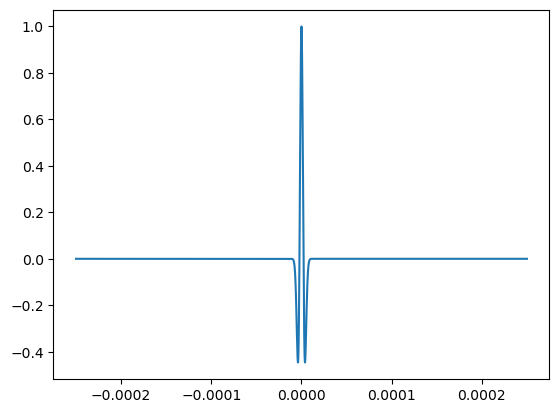

In [14]:
# Set wavelet and time sampling
nt = 50001  # two seconds at 4ms sampling
dt = 1e-8
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:int(nt//2)], f0=100000) # Central frequency 20Hz
plt.plot(wavt,wav)

In [52]:
def _sf2(x):
    x = float(np.format_float_positional(x, precision=2, unique=False, fractional=False, trim='k'))
    return x

def synth_traces(tts,t, wav, igwindow=15000):
    tts = np.around(tts,6)
    
    fbs = np.zeros([len(tts)])
    synth_rf = np.zeros([len(tts),len(t)])
    synth = np.zeros_like(synth_rf)
    
    vec_sf2 = np.vectorize(_sf2)
    tt2sf = vec_sf2(tts)
    t = vec_sf2(t)
    
    for i,tt in enumerate(tt2sf):
#         print(tt)
        ti = np.where(t==tt)[0]
        fbs[i] = ti[0]
#         print(ti)
        synth_rf[i,ti+igwindow] = 1
        synth[i] = np.convolve(wav,synth_rf[i], mode='same')
        
    return synth, synth_rf, fbs

In [53]:
# slowness will de assigned to grid nodes, we must pass cell_slowness=False
grid = rg.Grid3d(x, y, z, cell_slowness=False)

In [54]:
src_loc = np.expand_dims(recs[:,0],axis=1)
src_loc.shape

(3, 1)

In [55]:
nr

13

In [56]:
# we need to input slowness
slowness = 1./mod_vp

TTtable = np.zeros([nr,nr])

for i in range(nr):
    src_loc = np.expand_dims(recs[:,i],axis=1)
    tts, rays = grid.raytrace(src_loc.T, 
                             recs.T, 
                             slowness, 
                             return_rays=True)
    TTtable[i] = tts
    
    
TTtableDF = pd.DataFrame(TTtable)

Text(0.5, 1.0, '3 Sty. at 10% inc.')

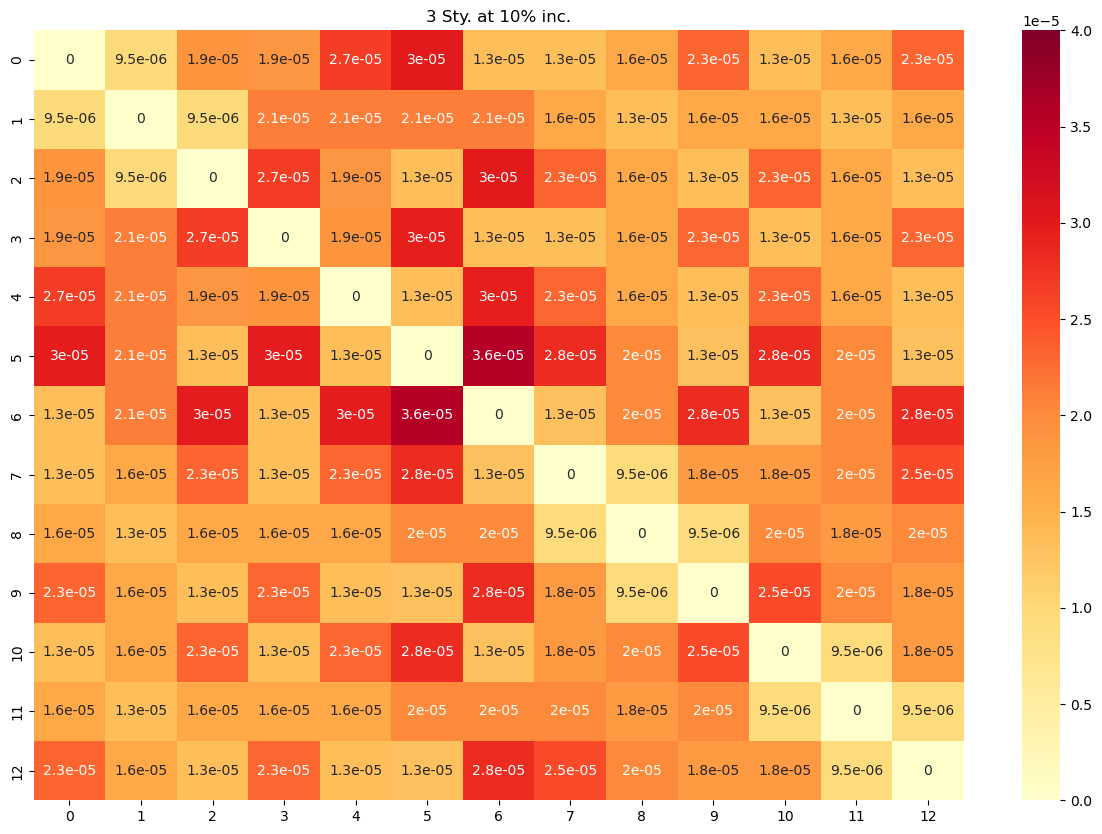

In [57]:
fig,ax = plt.subplots(1,1,figsize=[15,10])
sns.heatmap(TTtableDF,annot=True, ax=ax, cmap='YlOrRd', vmin=0, vmax =4e-5)
# fig.suptitle('CLEAN HOMO - Travel Times')
plt.title('3 Sty. at 10% inc.')

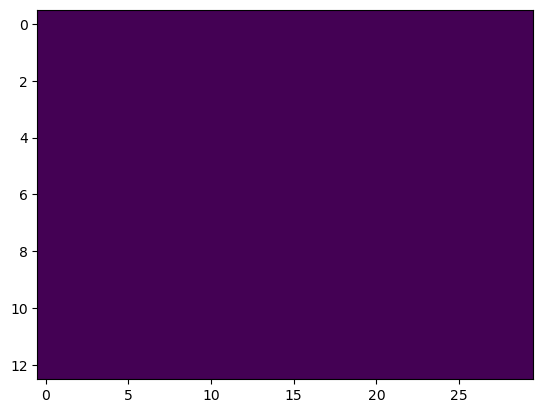

In [20]:
synth, synth_rf,fbs  = synth_traces(tts,t,wav)
plt.imshow(synth_rf[:,:30], aspect='auto')

In [21]:
fbs

array([2250., 1550., 1250., 2250., 1250., 1250., 2950., 2650., 2050.,
       1851., 1851.,  996.,    0.])

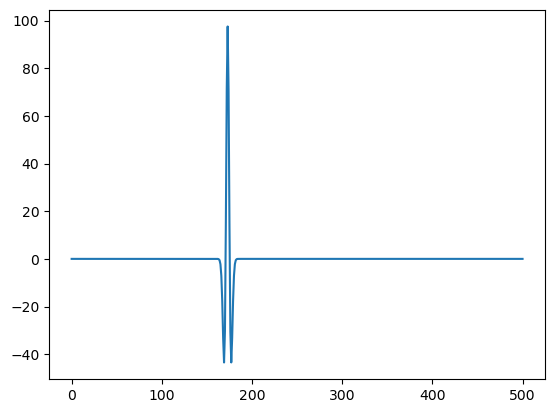

In [22]:
plt.plot(synth[0,::100])

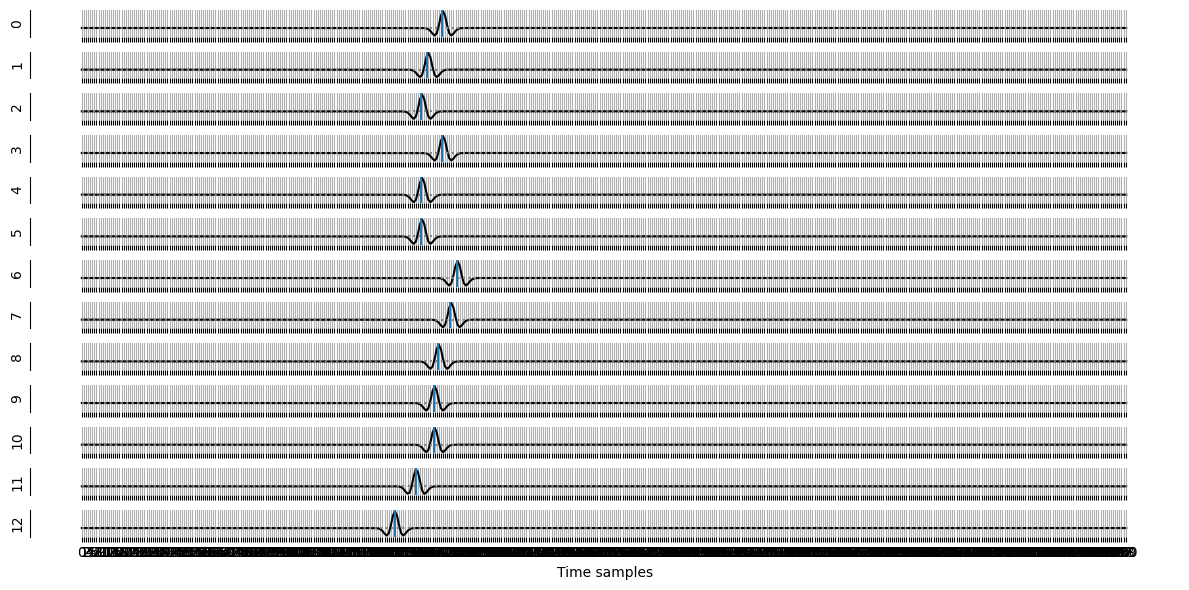

In [23]:
fig,axs = wiggleplot(synth[:,::100])
for i,ax in enumerate(axs):
    ax.axvline(x=150+fbs[i]/100)

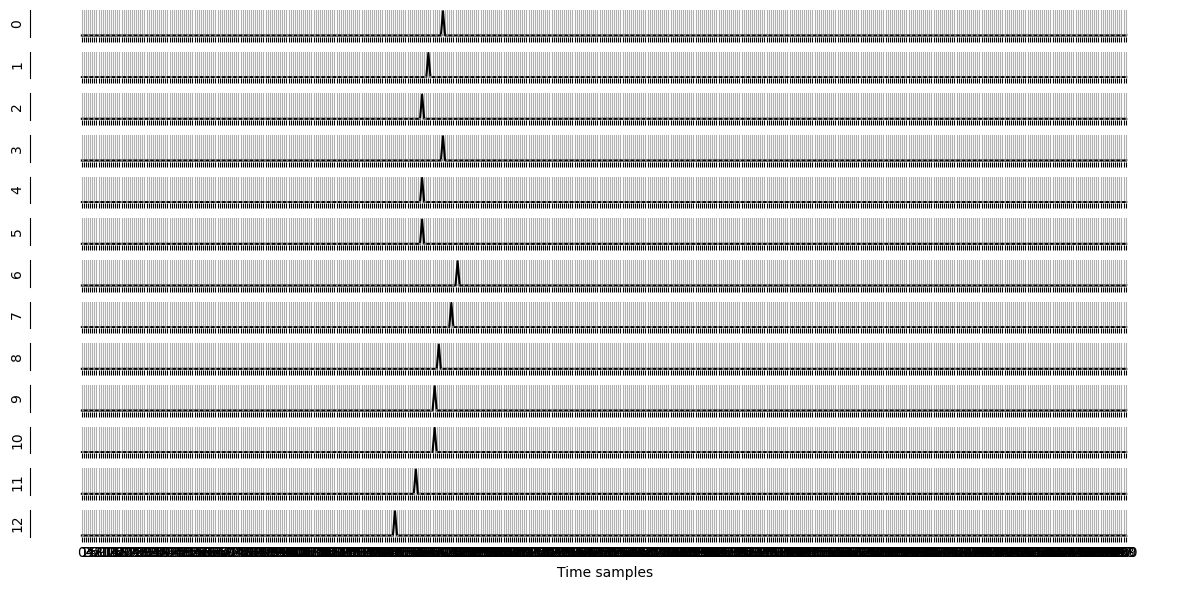

In [24]:
fig,axs = wiggleplot(synth_rf[:,::100])

In [25]:
tt[1]

NameError: name 'tt' is not defined

In [ ]:
plt.scatter(tt,np.arange(len(tt)))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x,y)
Z0, Z1 = z[0]*np.ones_like(X), z[-1]*np.ones_like(X)
ax.plot_surface(X,Y,Z1, color='grey', alpha=0.5, zorder=0.3)
ax.plot_surface(X,Y,Z0,color='grey',  alpha=0.5, zorder=0.3)


for r in rays:
    ax.plot(r[:,0], r[:,1], r[:,2],':k')
ax.scatter3D(xs=recs[0], ys=recs[1], zs=recs[2], c='r', marker='v', edgecolor='k')
ax.scatter3D(xs=src_loc[0], ys=src_loc[1], zs=src_loc[2], c='r', marker='*', s=50, edgecolor='k')



# Orientation 
# ax.azim = 10  # rotation around the z axis
# ax.dist = 0  # distance from the center visible point in data coordinates.
# ax.elev = 0  # angle between the eye and the xy plane.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# X, Y = np.meshgrid(x,y)
# Z0, Z1 = z[0]*np.ones_like(X), z[-1]*np.ones_like(X)
# ax.plot_surface(X,Y,Z1, color='grey', alpha=0.5, zorder=0.3)
# ax.plot_surface(X,Y,Z0,color='grey',  alpha=0.5, zorder=0.3)

cut = mod_vp[:,:,-1]
min_val = mod_vp.min()
max_val = mod_vp.max()
colormap = plt.cm.plasma

n_x, n_y, n_z = mod_vp.shape
X, Y = np.meshgrid(x,y)
Z = z[-1] + np.zeros_like(X)

# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colormap((cut-min_val)/(max_val-min_val)),
ax.plot_surface(X, Y, Z, facecolors=colormap((cut-min_val)/(max_val-min_val)), 
                alpha=0.5, zorder=0.3, antialiased=False)


# ax.plot_surface(X,Y1,Z, color='grey', alpha=0.5, zorder=0.3, antialiased=False)
# ax.plot_surface(Z0,X,Y, color='grey', alpha=0.5, zorder=0.3)
# ax.plot_surface(Z1,X,Y, color='grey', alpha=0.5, zorder=0.3)

# for r in rays:
#     ax.plot(r[:,0], r[:,1], r[:,2],':k')
# ax.scatter3D(xs=recs[0], ys=recs[1], zs=recs[2], c='r', marker='v', edgecolor='k')
# ax.scatter3D(xs=src[0], ys=src[1], zs=src[2], c='r', marker='*', s=50, edgecolor='k')



# Orientation 
# ax.azim = 10  # rotation around the z axis
# ax.dist = 0  # distance from the center visible point in data coordinates.
# ax.elev = 0  # angle between the eye and the xy plane.